In [74]:
import json
import ee
import numpy as np
import time
import subprocess
import sys
import os
import datetime as dt

try:
    import gdal
    import ogr
    import ogr
except:
    from osgeo import gdal
    from osgeo import ogr
    from osgeo import osr    

import matplotlib.pyplot as plt

# initialize ee
ee.Initialize()

%matplotlib inline

### Key User Input
Here is the kernel where we include key parameters which define our downloads. These are the following:<br>
 - **shapefile_name**: This is the path to the shapefile which defines the spatial area we are interested in.<br>
 - **key**: This is the extension that all files will have attached to them to identify the files.<br>
 - **year**: The year of data we want to download. We download only a year to keep the data volumes low. <br>
 - **download_directory**: Where we want to place the downloaded data.  

In [7]:
shapefile_name = '/media/DataShare/Alex/un_surinam/eo4sgs_second_aoi_edited_FINAL.geojson'
key = 'test_download'
year = 2019
download_directory = '.'

We will be using the Google Earth Engine to to download the data. This is a huge repository of petabytes of data where we can cleanly aquire data for any given region within the timeframe available from each sensor. This is done in the python API by constructing a call to their API, filtering the dataset to the area and time we want and then we can export this 'Image collection' to a google 'asset'. To view all the available dataset available with Google Earth Engine, see this link: https://developers.google.com/earth-engine/datasets/catalog <br><br>
To learn more about how to use the Google Earth Engine, please refere to the following:
https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api <br><br>
Below is where we construct the call to the sensor ( Sentinel 2 https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED#description)

In [31]:
# Specifiy the product we are interested in. This is unique to each sensor
# and found on each the product specification page
product = 'COPERNICUS/S2_SR_HARMONIZED'

# setout how you want label this data. As we are using Sentinel 2 we can use
# the following
dataset_custom_tag = 'S2_SR_suriname'

# we can open the geojson with the 'json' toolbox
geoj = json.load(open(shapefile_name, 'r'))
# we then use this json to create a Google Earth Engine Geometry Object 
geometry = ee.Geometry.Polygon(geoj['features'][0]['geometry']['coordinates'][0])

# to filter the time, we use strings with the following format
# YYY-MM-DD
start_date = '%s-01-01'%year
end_date = '%s-12-31'%year

# specificy the bands we want. These can be found here:
# hhttps://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

# finally, it is good to force Google Earth Engine to use the 
# native resolution
resolutions = [10, 10, 10, 20, 20, 20, 10, 20, 20, 20]

# create the Image Collection
ee_collection = (ee.ImageCollection(product).
                 filterBounds(geometry).
                 filterDate(start_date, end_date).
                 select(bands))
                 ######
                 ## use this line to filter the data on cloudey percentage
                 # filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)))

In [32]:
# you can interact with the immage collections with a few basic commands
# but we dont need to do anything else to the Image Collection to download
# the data. 
print ('Number of Image Aquisitions:')
print (ee_collection.size().getInfo())

Number of Image Aquisitions:
72


To download the Image Collection, we need a two step process. Firstly we need to export the datasets to a Google Drive and then we can export from the Drive to the local machine, using gsutils. This works by individually exporting all data for each band to the Drive, which is a time consuming process as the Earth Engine acually does the processing in this stage for us. We wait in the 'while' loop until this prcoess is completed. We then use 'gsutils' which is a linux command line toolbox, which we call from python. 

In [33]:
# create a list to put the tasks in so we can check their progress
tasks = []

# loop throguh each Landsat 5 band and export them to the google drive
for resolution, band in zip(resolutions, bands):
    
    # create a unique key to attach to the data     
    unique_desc = f'{key}_{band}'
    
    # USER INPUT
    # the user must use the following command to export the data
    # https://developers.google.com/earth-engine/apidocs/export-image-todrive
    
    DRIVE_NAME = 'adas_s1'
    
    task = ee.batch.Export.image.toCloudStorage(
        image = ee_collection.select(band).toBands(),
        region = geometry,
        description = unique_desc,
        bucket = DRIVE_NAME,
        fileNamePrefix = '%s_%s_%s_%s'%(dataset_custom_tag, key, 
                                        year, band),
        scale = resolution,
        maxPixels = 1e13)
    
    tasks.append(task)

for task in tasks:
    task.start()

# continue in this while loop until all the tasks are finished. Once
# complete they will be sitting on the google bucket

# record when we started waiting for the data
start = time.time()

while len([i.status()['state'] for i in tasks if i.status()['state'] == 'COMPLETED']) < len(bands):

    # use the command line 'earthengine' package to find how our 
    # downloads are going
    result = subprocess.run(['earthengine', 'task', 'list'], stdout=subprocess.PIPE)
     # get information for the most recent tasks, which is what
    # we are waiting for
    output = str(result.stdout).replace('  Export.image  ','').split('\\n')[:10]
    # format all this information
    trimmed = [[i for i in j.split(' ') if len(i) > 0] for j in output]
    prnt_lines = ['%s - %s'%(i[0],i[1]) for i in trimmed]

    second_dif = str(int(time.time() - start))+'s'
    second_dif_str_second = f"{second_dif:<5}"
    second_dif_str = '(S2 %s %s) %s'%(key,year,second_dif_str_second)
    prnt = '%s - %s // %s // %s // %s // %s // %s // %s // %s // %s // %s'%(second_dif_str,prnt_lines[0][2:],prnt_lines[1],prnt_lines[2],
                                                    prnt_lines[3],prnt_lines[4],prnt_lines[5],prnt_lines[6],
                                                   prnt_lines[7],prnt_lines[8],prnt_lines[9])

    sys.stdout.write('%s\r' % (prnt,))
    sys.stdout.flush()
    # there are four possible state of the task which will be printed out:
    # READY
    # RUNNING
    # COMPLETED
    # FAILED

In [21]:
# to cancel the downloads, in the linux command line do the following:
# >earthengine task cancel all

# or in python:
os.system('earthengine task cancel all')

Canceling task "L5U5WLNFZAJW5S67H36RIH7X"
Canceling task "NHCXHSMRPK4HFD5J2SUKFLMD"
Canceling task "TPA22TM7PYN6SBPCKJUT6EUH"
Canceling task "MV3JKEVPTAQE3KZ5VJ6OGK4N"
Canceling task "PA2FYKFVZMVRIMJ3LJE6CZBJ"
Canceling task "53XJ24RFEPKTAFZJD6K3TYJH"
Canceling task "BOIRZOKCN3KAO3DTZUVOKIX6"
Canceling task "CBESFWA7FFRDRNP2XFP77H2O"
Canceling task "VQI6BFJWDLARWMPHE2CT6SXR"
Canceling task "NNPQJR64KM3R6RTAD6OTHXPX"


0

## Download attached metadata

In [34]:
# all details for the cliud masking is found here:
# https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless

acm_params = {'CLD_PRB_THRESH': 45,
              'NIR_DRK_THRESH': 0.25,
              'CLD_PRJ_DIST': 2,
              'BUFFER': 70}

def add_cloud_bands(img):

    #DEFAULT CLD_PRB_THRESH = 50
    CLD_PRB_THRESH = acm_params['CLD_PRB_THRESH']

    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

def add_shadow_bands(img):

    NIR_DRK_THRESH = acm_params['NIR_DRK_THRESH']
    CLD_PRJ_DIST = acm_params['CLD_PRJ_DIST']

    # Identify water pixels from the SCL band.
    # scl is the landcover classification and 6 is water
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    # this returns a 1 if the B8 pixels are over the threshold - so likely cloud shadow
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    # this is just a single number
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

def add_cld_shdw_mask(img):

    #DEFAULT BUFFER= 50 
    BUFFER = acm_params['BUFFER']

    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    is_cld_shdw = (is_cld_shdw.focal_min(2).focal_max(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 10})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)


bands = ['B8','SCL']

s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR')
            .filterBounds(geometry)
            .filterDate(start_date, end_date)
            .select(bands))


# Import and filter s2cloudless.
s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
    .filterBounds(geometry)
    .filterDate(start_date, end_date))

# Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
filter_dict = {'primary': s2_sr_col,'secondary': s2_cloudless_col,
                'condition': ee.Filter.equals(**{'leftField': 'system:index','rightField': 'system:index'})}

basic_collection = ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**filter_dict))

masking_ee_collection = basic_collection.map(add_cld_shdw_mask)    

print ('Size of masking data:')
print (masking_ee_collection.size().getInfo())

Size of masking data:
72


#### Download the cloud maksing data

In [36]:
masking_bands = ['clouds','cloud_transform','dark_pixels','probability','shadows','cloudmask']
masking_resolutions = [10,10,10,10,10,10]

# create a list to put the tasks in so we can check their progress
tasks = []

# loop throguh each Landsat 5 band and export them to the google drive
for resolution, band in zip(masking_resolutions, masking_bands):
    
    # create a unique key to attach to the data     
    unique_desc = f'{key}_{band}'
    
    DRIVE_NAME = 'adas_s1'
    
    task = ee.batch.Export.image.toCloudStorage(
        image = masking_ee_collection.select(band).toBands(),
        region = geometry,
        description = unique_desc,
        bucket = DRIVE_NAME,
        fileNamePrefix = '%s_%s_%s_%s'%(dataset_custom_tag, key, 
                                        year, band),
        scale = resolution,
        maxPixels = 1e13)
    
    tasks.append(task)

for task in tasks:
    task.start()

# continue in this while loop until all the tasks are finished. Once
# complete they will be sitting on the google bucket

start = time.time()
while len([i.status()['state'] for i in tasks if i.status()['state'] == 'COMPLETED']) < len(tasks):

    result = subprocess.run(['earthengine', 'task', 'list'], stdout=subprocess.PIPE)
    output = str(result.stdout).replace('  Export.image  ','').split('\\n')[:15]
    trimmed = [[i for i in j.split(' ') if len(i) > 0] for j in output]
    prnt_lines = ['%s - %s'%(i[0],i[1]) for i in trimmed[:-1]]
    second_dif = str(int(time.time() - start))+'s'
    second_dif_str_second = f"{second_dif:<5}"
    second_dif_str = '(ACM %s %s) %s'%(key,year,second_dif_str_second)
    prnt = '%s - %s // %s // %s // %s // %s // %s'%(second_dif_str,prnt_lines[0][2:],prnt_lines[1],prnt_lines[2],
                                                    prnt_lines[3],prnt_lines[4],prnt_lines[5])

    sys.stdout.write('%s\r' % (prnt,))
    sys.stdout.flush()

## Finally move everything from the cloud to your local machine

In [43]:
# once this is done, we use gsutils to move this data from the Drive to 
# your local machine. 

# check the output directory exists and create if needs be
dest = os.path.join(download_directory)
if os.path.isdir(dest) == False:
    os.makedirs(dest)
    
# constrcut the command line call
cmd = 'gsutil mv gs://%s/%s_%s_%s* %s/'%(DRIVE_NAME, 
                                         dataset_custom_tag,
                                         key, year, dest)

print ('Starting data downloads:')
# use python to call this command and move the data
subprocess.call(cmd, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)    

Starting data downloads:


0

## Lets quickly look at the data

In [44]:
b2_opn = gdal.Open('S2_SR_test_download_2019_B2.tif')
cp_opn = gdal.Open('S2_SR_test_download_2019_probability.tif')
cm_opn = gdal.Open('S2_SR_test_download_2019_cloudmask.tif')
[i.RasterCount for i in [b2_opn,cp_opn,cm_opn]]

[72, 72, 72]

(-1.0, 72.0)

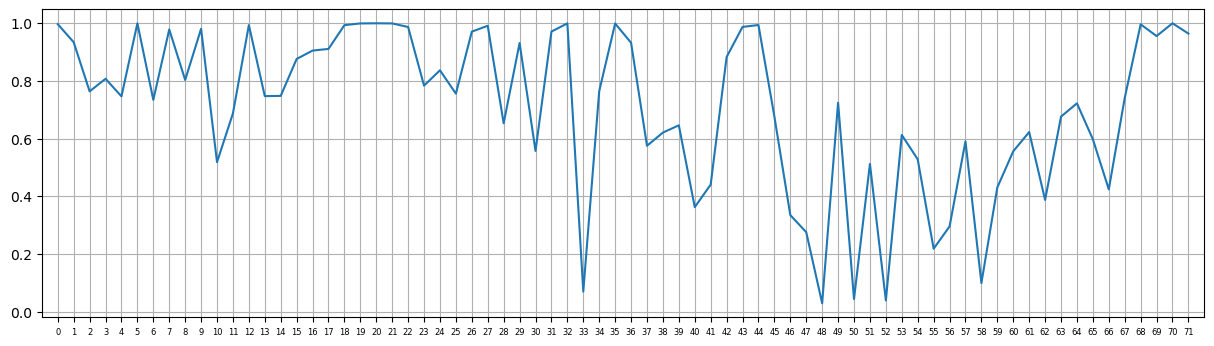

In [67]:
# look at the cloud probability averaged accross the scene
cp_arr = cm_opn.ReadAsArray()
av_cp = np.nanmean(cp_arr, axis=(1,2))

plt.figure(figsize=(15,4))
plt.plot(av_cp)
_ = plt.xticks(np.arange(b2_opn.RasterCount),fontsize=6)
plt.grid()
plt.xlim(-1,72)

In [69]:
# due to the size of the dataset, only open individual rasters
rst_num = 11
b2_rst = b2_opn.GetRasterBand(rst_num)
b2_arr = b2_rst.ReadAsArray()

cp_rst = cp_opn.GetRasterBand(rst_num)
cp_arr = cp_rst.ReadAsArray()

cm_rst = cm_opn.GetRasterBand(rst_num)
cm_arr = cm_rst.ReadAsArray()

# there is a scale for sentinel 2 band data
scale = 1/10000
offset = 0
b2_arr = b2_arr*scale + offset

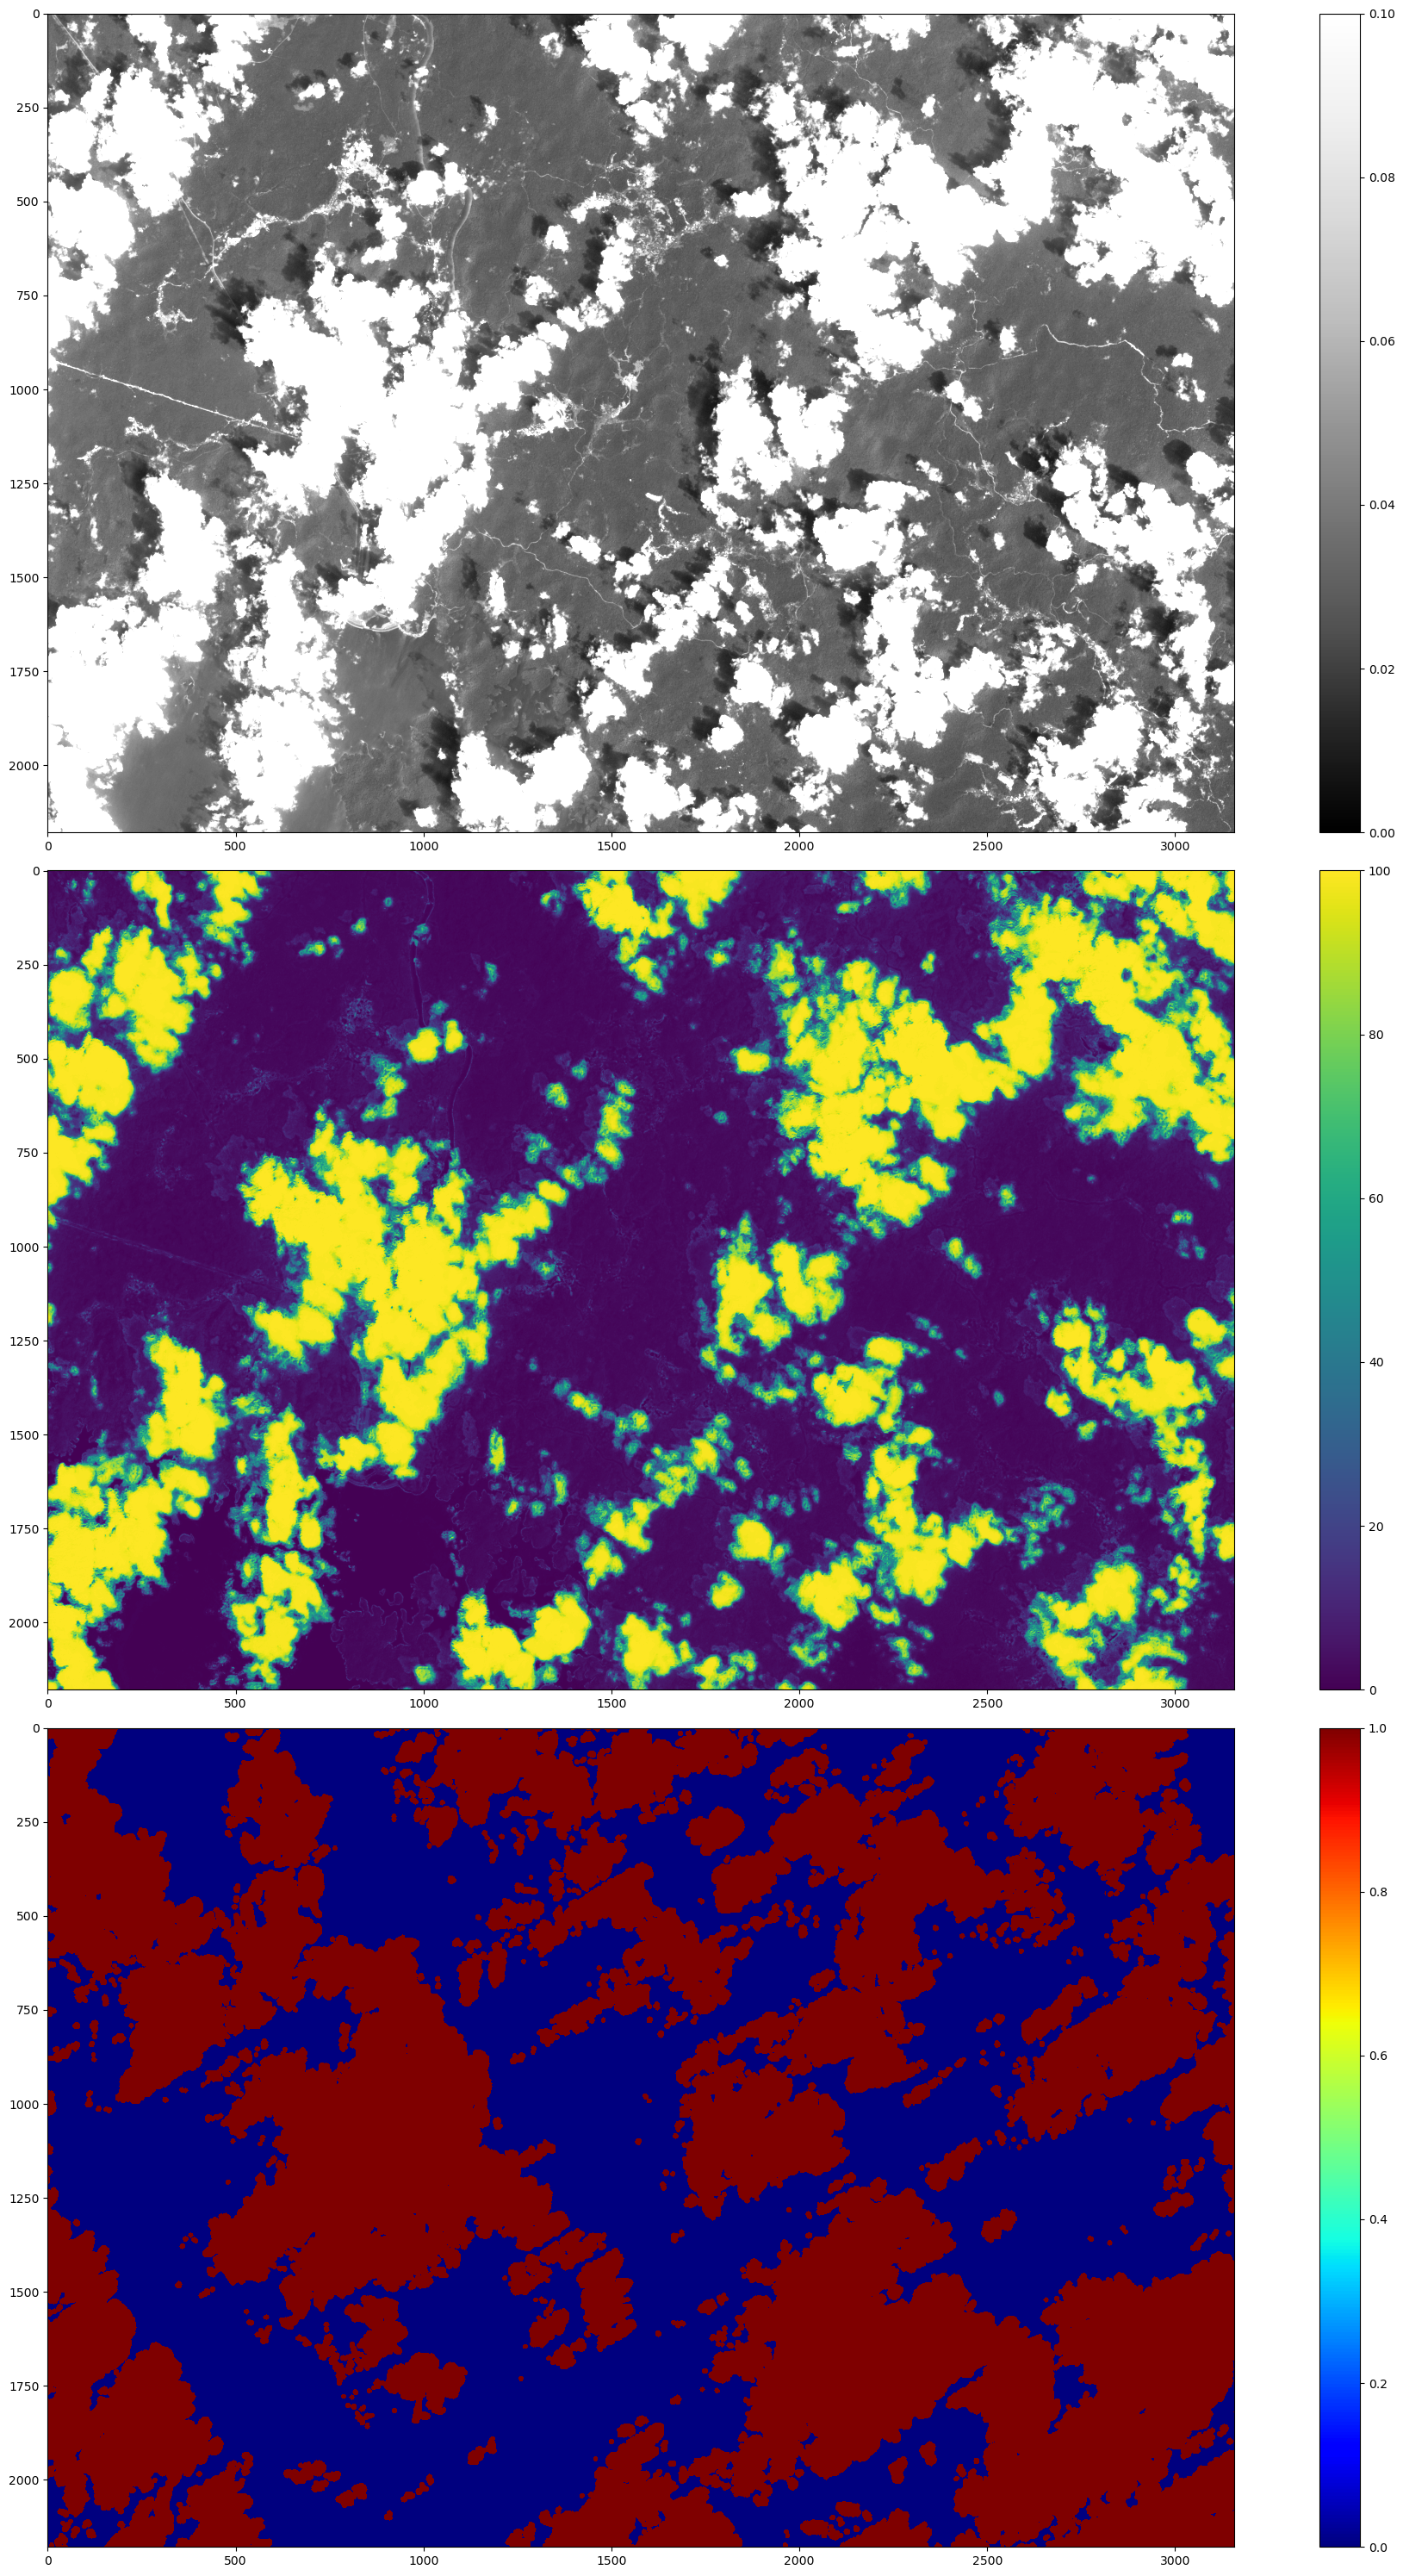

In [70]:
fig,axs = plt.subplots(3,1,figsize=(20,30))
im = axs[0].imshow(b2_arr,vmax=0.1,cmap='Greys_r')
plt.colorbar(im, ax=axs[0])

im = axs[1].imshow(cp_arr)
plt.colorbar(im, ax=axs[1])

im = axs[2].imshow(cm_arr,cmap='jet',interpolation='none')
plt.colorbar(im, ax=axs[2])

plt.tight_layout()

### Metadata

In [71]:
b2_rst.GetDescription()

'20190224T141049_20190224T141045_T21NYF_B2'

In [80]:
# metadata attached to the data holds the 'system:index'
# this holds when the data was aquired
system_index = [b2_opn.GetRasterBand(i).GetDescription() for i in range(1,b2_opn.RasterCount+1)]
print (system_index[:10])
aquisition_dates = [dt.datetime.strptime(i.split('_')[0],'%Y%m%dT%H%M%S') for i in system_index]
aquisition_dates[:10]

['20190105T141049_20190105T141044_T21NYF_B2', '20190110T141041_20190110T141041_T21NYF_B2', '20190115T141049_20190115T141045_T21NYF_B2', '20190120T141041_20190120T141042_T21NYF_B2', '20190125T141049_20190125T141046_T21NYF_B2', '20190130T141041_20190130T141043_T21NYF_B2', '20190204T141049_20190204T141046_T21NYF_B2', '20190209T141041_20190209T141043_T21NYF_B2', '20190214T141049_20190214T141046_T21NYF_B2', '20190219T141041_20190219T141042_T21NYF_B2']


[datetime.datetime(2019, 1, 5, 14, 10, 49),
 datetime.datetime(2019, 1, 10, 14, 10, 41),
 datetime.datetime(2019, 1, 15, 14, 10, 49),
 datetime.datetime(2019, 1, 20, 14, 10, 41),
 datetime.datetime(2019, 1, 25, 14, 10, 49),
 datetime.datetime(2019, 1, 30, 14, 10, 41),
 datetime.datetime(2019, 2, 4, 14, 10, 49),
 datetime.datetime(2019, 2, 9, 14, 10, 41),
 datetime.datetime(2019, 2, 14, 14, 10, 49),
 datetime.datetime(2019, 2, 19, 14, 10, 41)]